## 1. Parâmetros do Problema:

* Condutividade térmica ($k$): $0.595 \, \text{W/mK}$.

* Massa específica ($\rho$): $997 \, \text{kg/m}^3$.

* Comprimento ($L$): $0,1 \, \text{m}$.

* Temperatura em x=0 ($T_0$): $150^\circ\text{C}$.

* Temperatura em x=L ($T_L$): $50^\circ\text{C}$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# Parâmetros Físicos (Lista 7)
k = 0.595                 # Condutividade térmica [W/mK]
rho = 997.0               # Densidade [kg/m³]
L = 0.1                   # Comprimento do domínio [m]
T0 = 150.0                # Temperatura em x=0 [°C]
TL = 50.0                 # Temperatura em x=L [°C]

Algoritmo para a solução do sistema de equações (TDMA):

In [2]:
# --- 1. Solver Linear (Algoritmo de Thomas - TDMA) ---

def solver_tdma(a, b, c, d):
    """Algoritmo de Thomas para sistemas tridiagonais"""
    n = len(d)
    P_star = np.zeros(n)
    Q_star = np.zeros(n)
    P_star[0] = c[0] / b[0]
    Q_star[0] = d[0] / b[0]
    for i in range(1, n):
        m = b[i] - a[i] * P_star[i-1]
        P_star[i] = c[i] / m
        Q_star[i] = (d[i] - a[i] * Q_star[i-1]) / m
    x = np.zeros(n)
    x[-1] = Q_star[-1]
    for i in range(n-2, -1, -1):
        x[i] = Q_star[i] - P_star[i] * x[i+1]
    return x



## 2 Equação Discretizada para os nós internos


A equação governante para a convecção-difusão unidimensional em regime permanente é dada por:

$$\frac{d}{dx}(\rho u T) = \frac{d}{dx}\left(k \frac{dT}{dx}\right)$$

Integrando sobre um volume de controle, obtemos o balanço de fluxos nas faces leste ($e$) e oeste ($w$):

$$(\rho u A T)_e - (\rho u A T)_w = \left( k A \frac{dT}{dx} \right)_e - \left( k A \frac{dT}{dx} \right)_w$$

Definindo o fluxo de massa ($F = \rho u$) e a condutância difusiva ($D = k / \delta x$), a equação assume a forma discretizada geral $a_P T_P = a_W T_W + a_E T_E + b$, onde os coeficientes dependem do esquema escolhido:

Esquema de Diferenças Centrais (CDS):

Assume que 

$$T_e = \frac{(T_P + T_E)}{2} \text{\qquad e \qquad }T_w = \frac{(T_W + T_P)}{2}$$

Assim: 

 * $a_W = D_w + F_w / 2$
 
 * $a_E = D_e - F_e / 2$

 * $a_P = a_P + a_W / 2$

 * $b =$ Termo fonte 


Esquema Upwind:

Assume que 

$$T_e = \frac{(T_P + T_E)}{2} \text{\qquad e \qquad }T_w = \frac{(T_W + T_P)}{2}$$

Assim: 

 * $a_W = D_w + F_w / 2$
 
 * $a_E = D_e - F_e / 2$

 * $a_P = a_P + a_W / 2 + (F_e-F_w)$

 * $b =$ Termo fonte 


$a_E = D_e - F_e / 2$

Esquema Upwind:

Atribui à face o valor do nó a montante (upstream).

Assim: 

$$a_P T_P = a_W T_W + a_E T_E + b$$

Onde: 
 * $a_W = D_w + \max(F_w, 0)$
 
 * $a_E = D_e + \max(-F_e, 0)$

 * $a_P = a_P + a_W / 2 + (F_e-F_w)$ 

 * $b =$ Termo fonte



Em ambos os casos, para regime permanente e velocidade constante ($F_e = F_w$), temos $a_P = a_W + a_E$.

## 2 Equação Discretizada para os nós na fronteira

Nas fronteira, os valores de $D_w$ e $D_e$ não são iguais, uma vez que a distância até o nó vizinho, $\delta x$, não igual em leste o oeste ( $\delta x_e \neq \delta x_w $). 

A seguir são apresentadas as deduções dos coeficientes da equação disctretizada para ambos os métodos:

### 2.1 EDC:

#### Fronteira esquerda (x=0)

$$a_P T_P = a_W T_W + a_E T_E + b$$

Onde:

 * $a_W = 0$
 
 * $a_E = D_e - F_e / 2$

 * $a_P = D_e + D_w$

 * $b = (D_w + F_w / 2) * T_0$ 

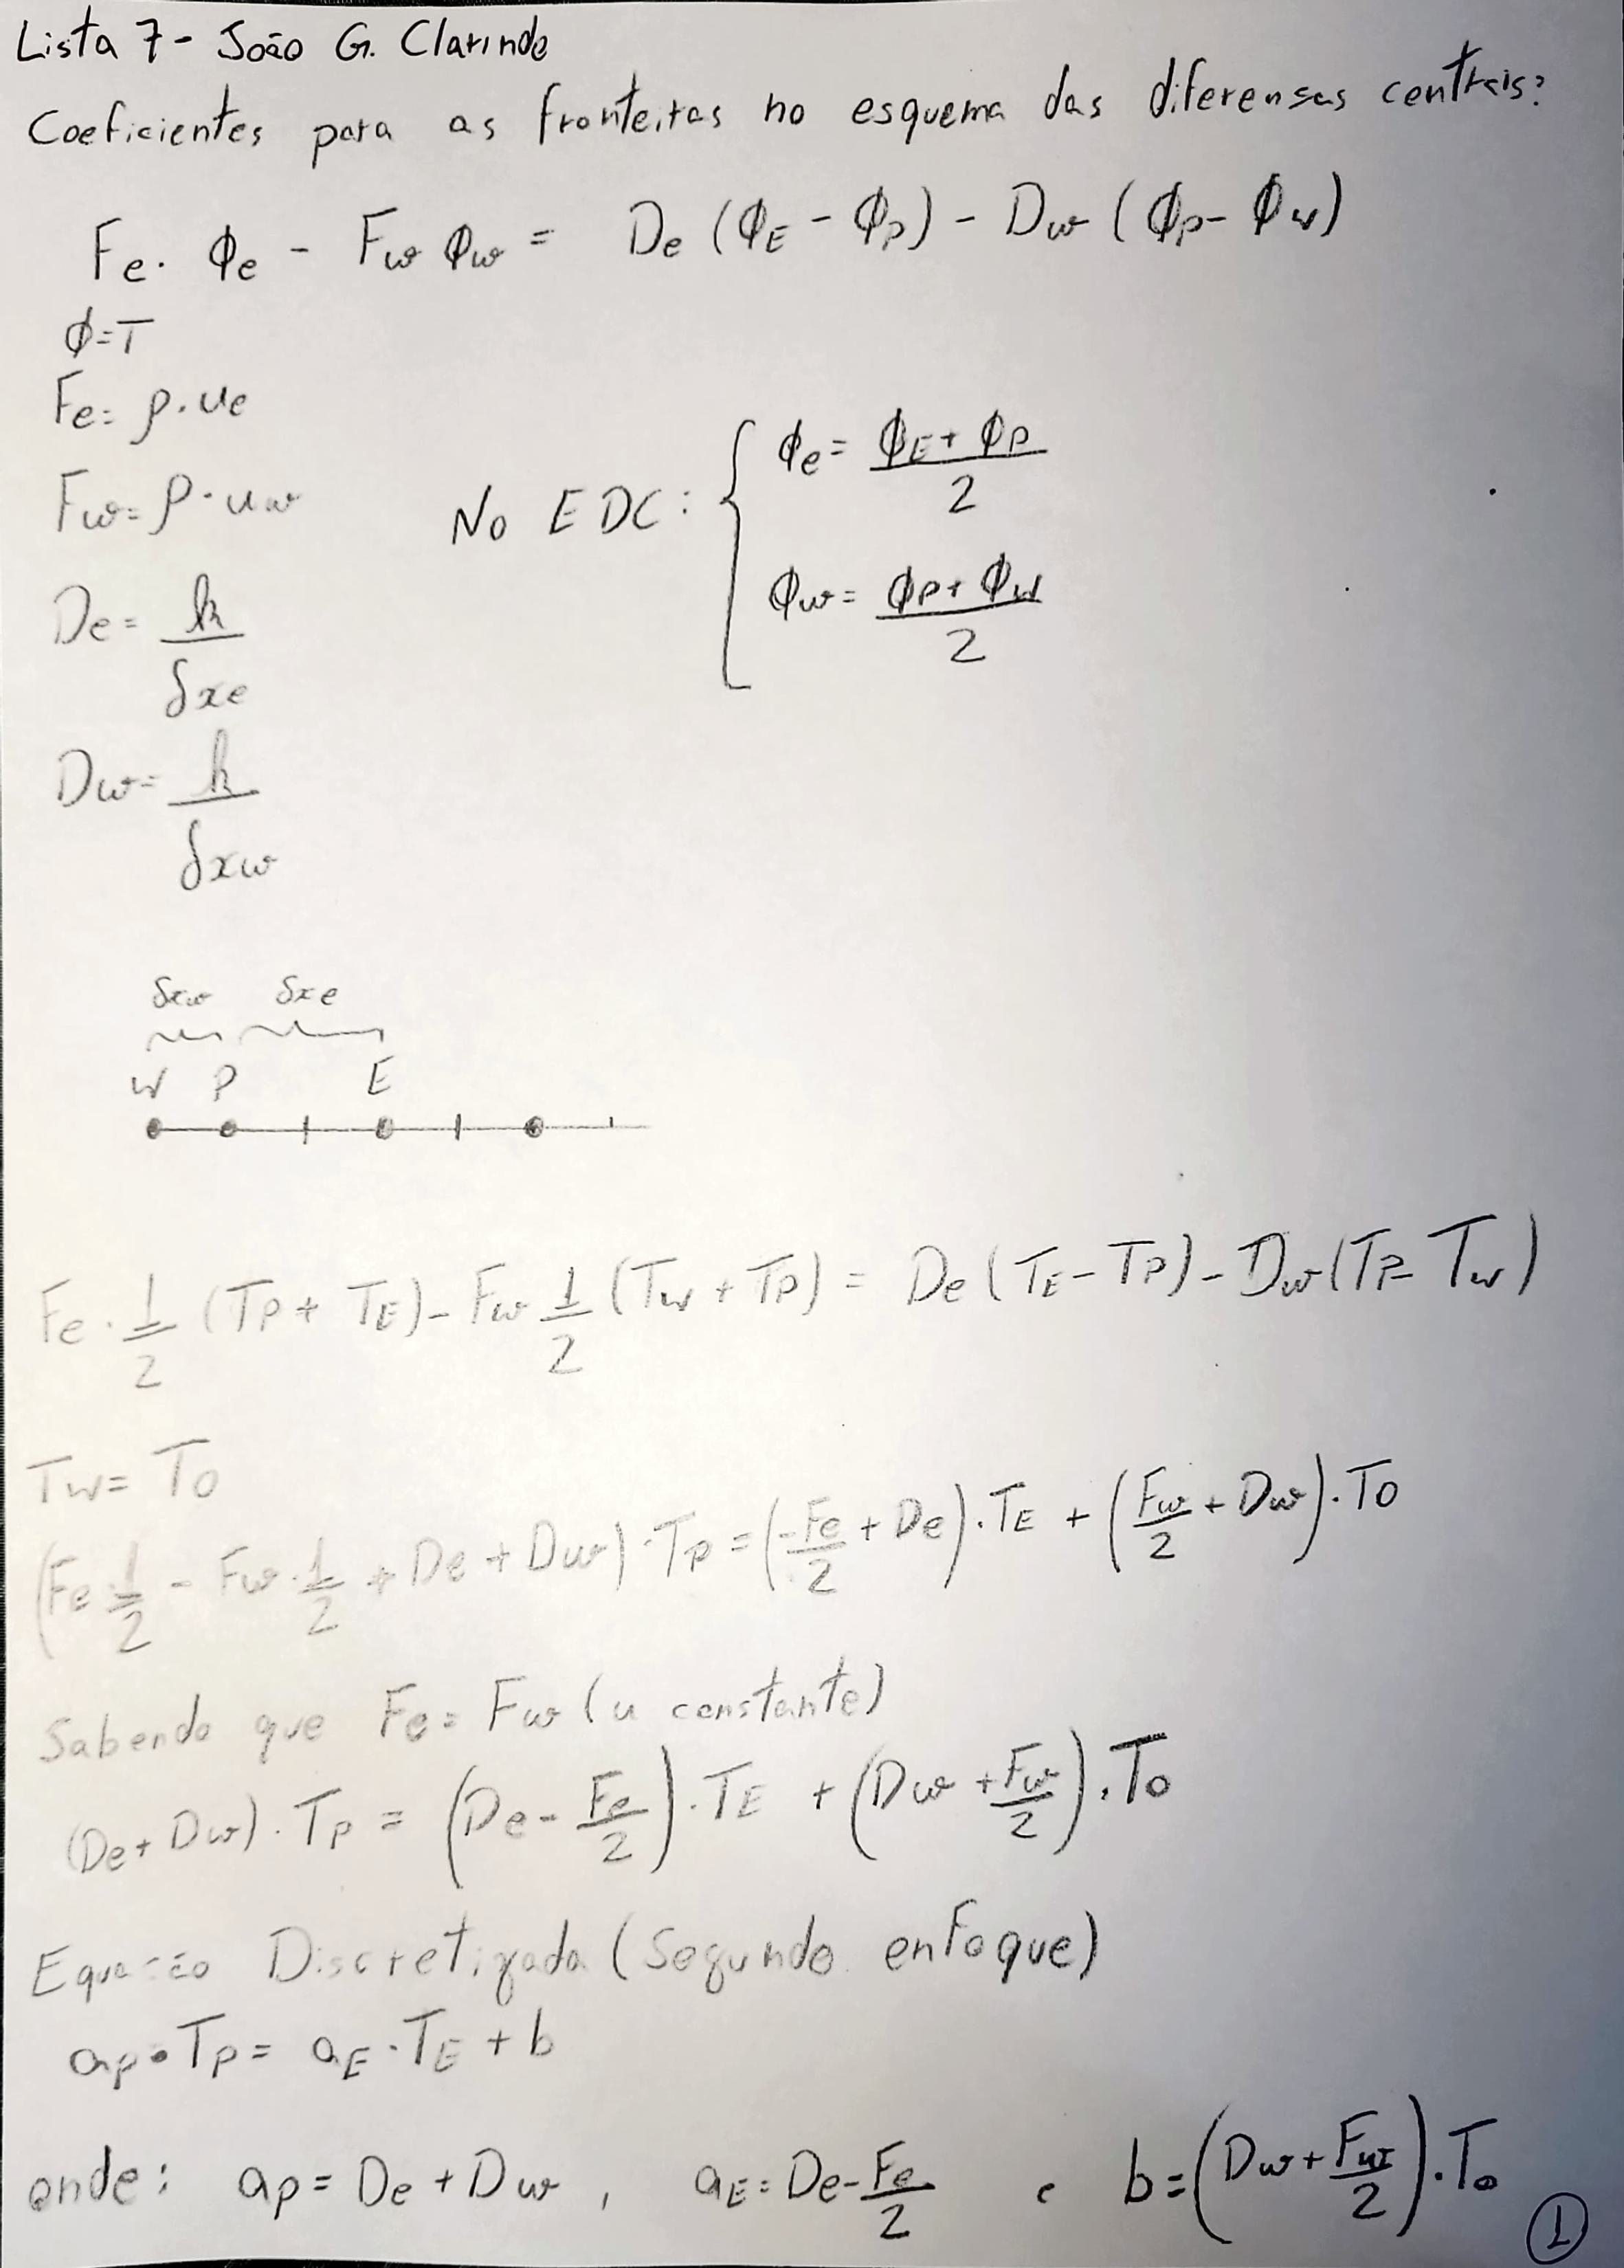

In [3]:
Image('Lista7_pag1.jpg',width=600)

#### Fronteira direita (x=0)

$$a_P T_P = a_W T_W + a_E T_E + b$$

Onde:

 * $a_W = D_w + F_w / 2$
 
 * $a_E = 0$

 * $a_P = D_e + D_w$

 * $b = (D_e - F_e / 2) * T_L$ 

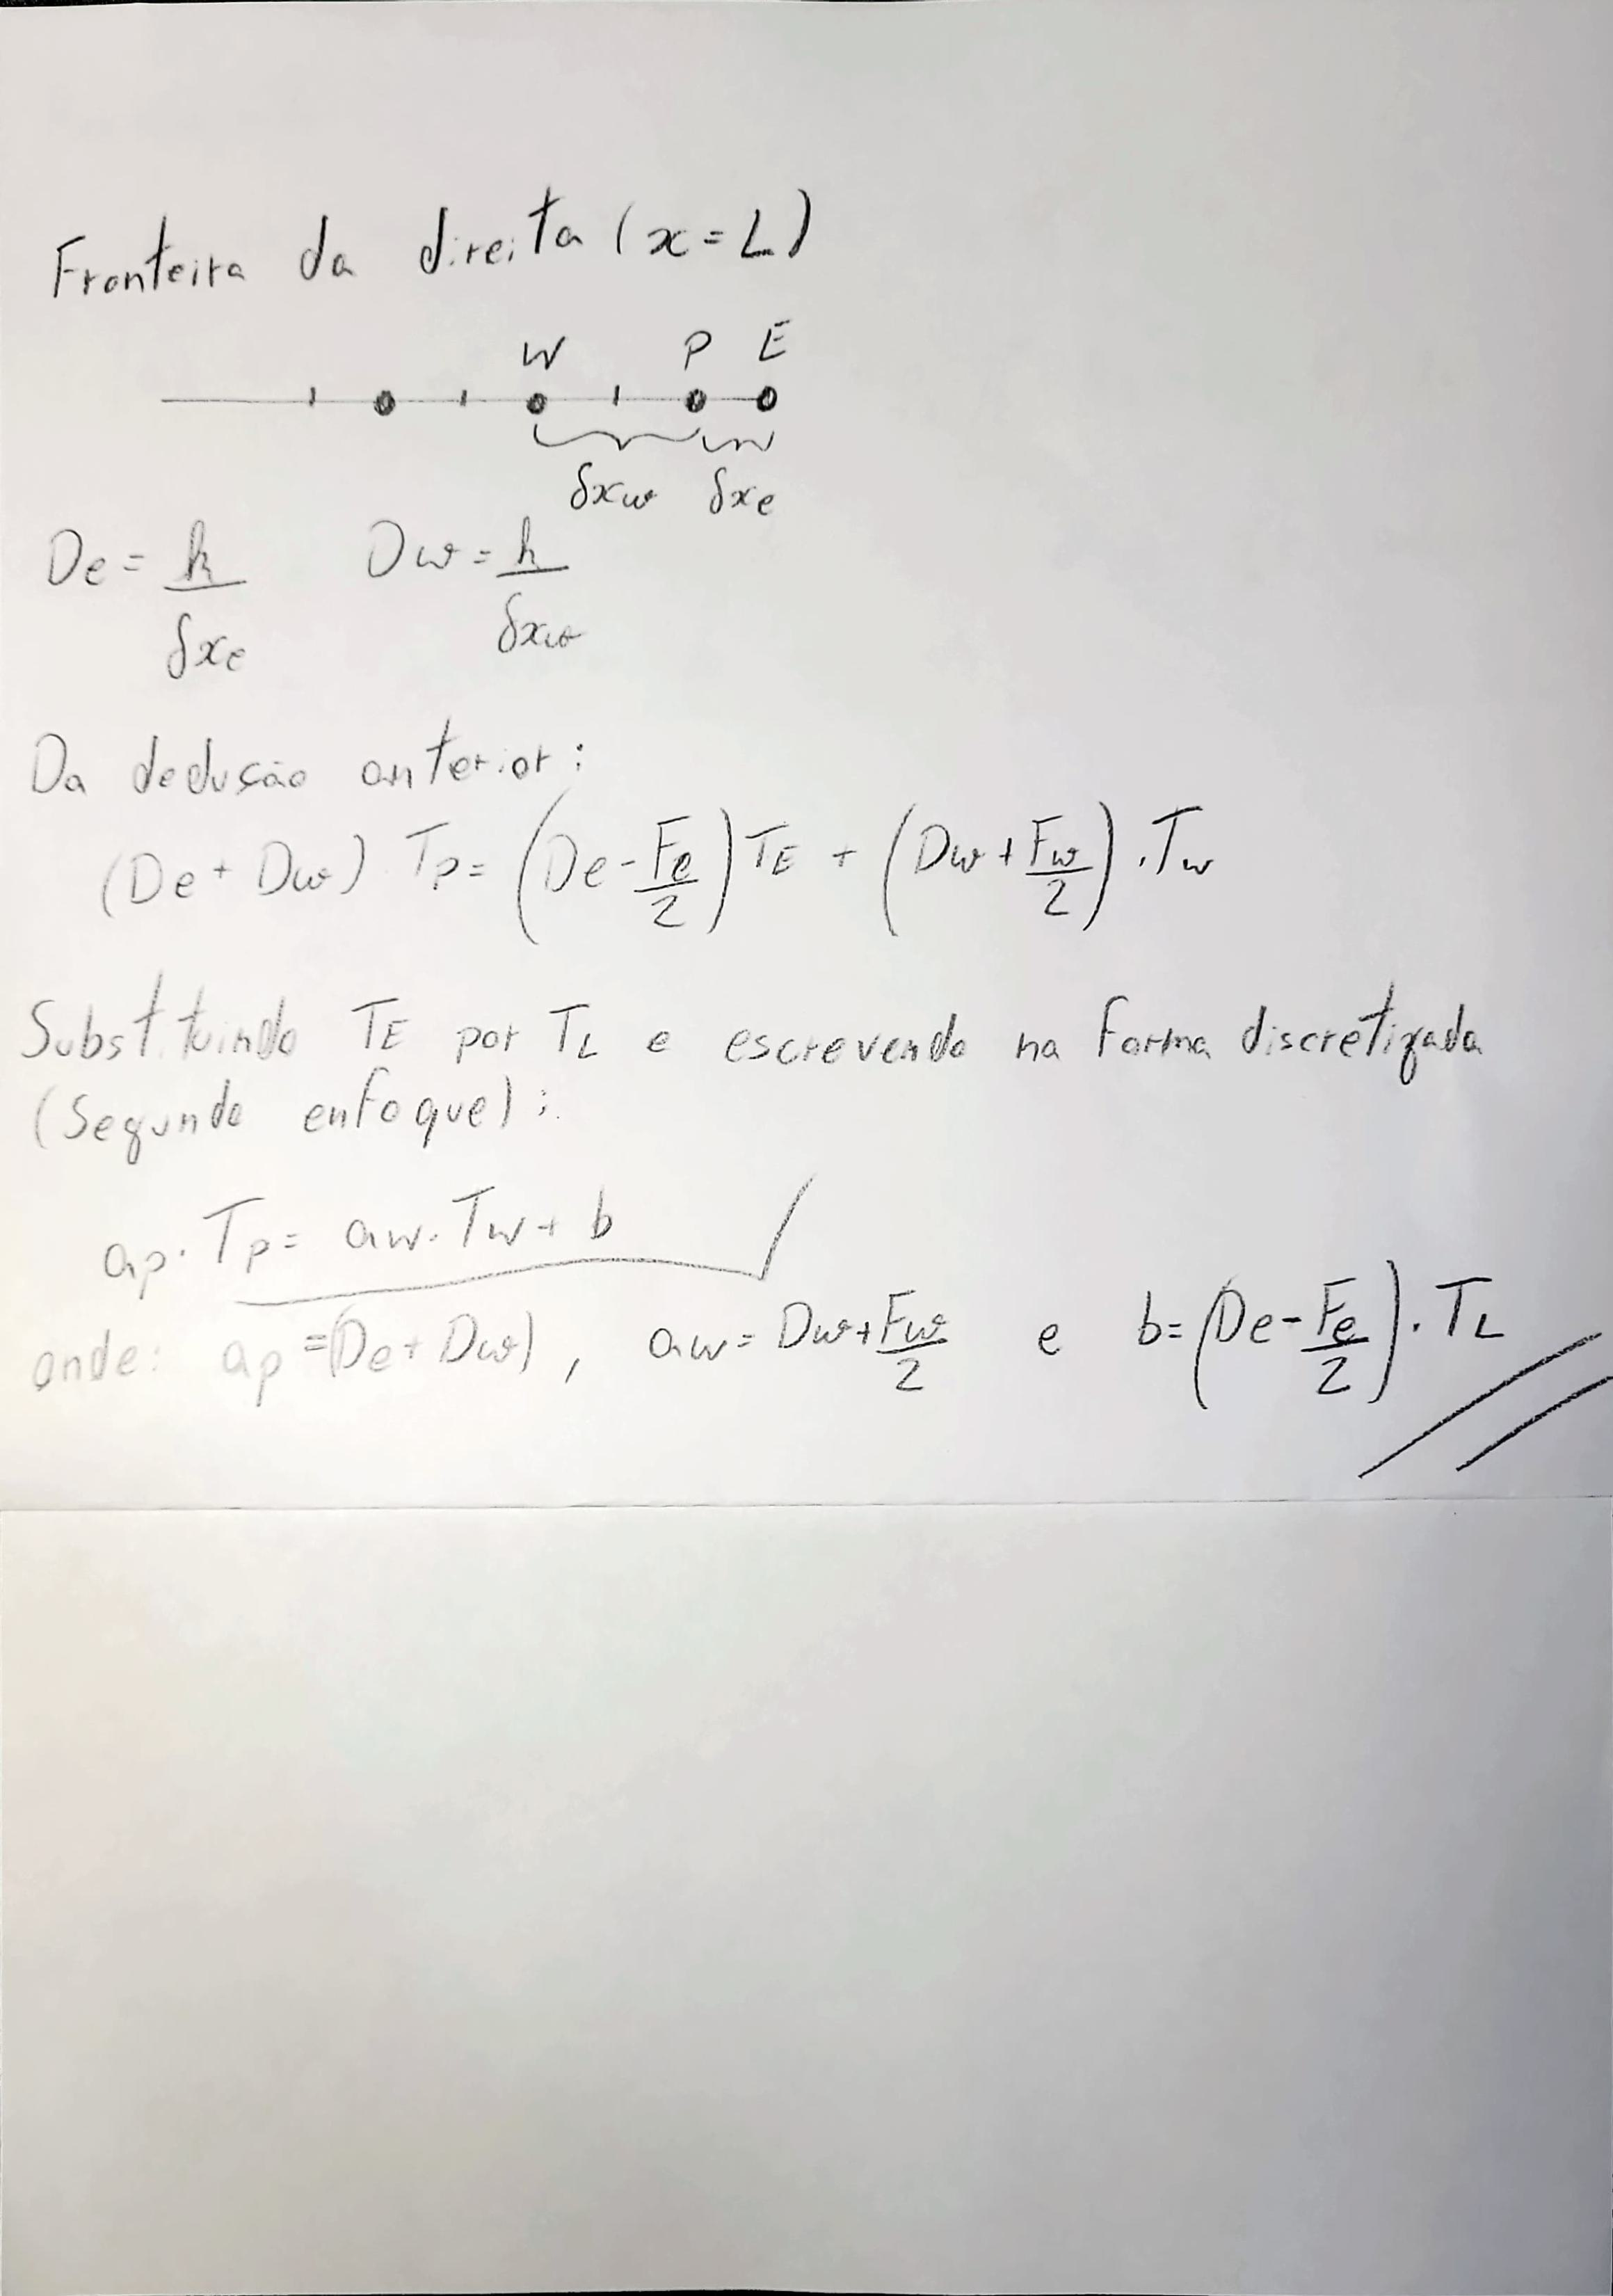

In [4]:
Image('Lista7_pag2.jpg',width=600)

### 2.2 Upwind:

#### Fronteira esquerda (x=0)

$$a_P T_P = a_W T_W + a_E T_E + b$$

Onde:

 * $a_W = 0$
 
 * $a_E = D_e$

 * $a_P = F_e + D_e + D_w$

 * $b = (D_w + F_w) * T_0$ 


#### Fronteira direita (x=L)


 * $a_W = F_w + D_w$
 
 * $a_E = 0$

 * $a_P = F_e + D_e + D_w$

 * $b = (D_e) * T_L$ 

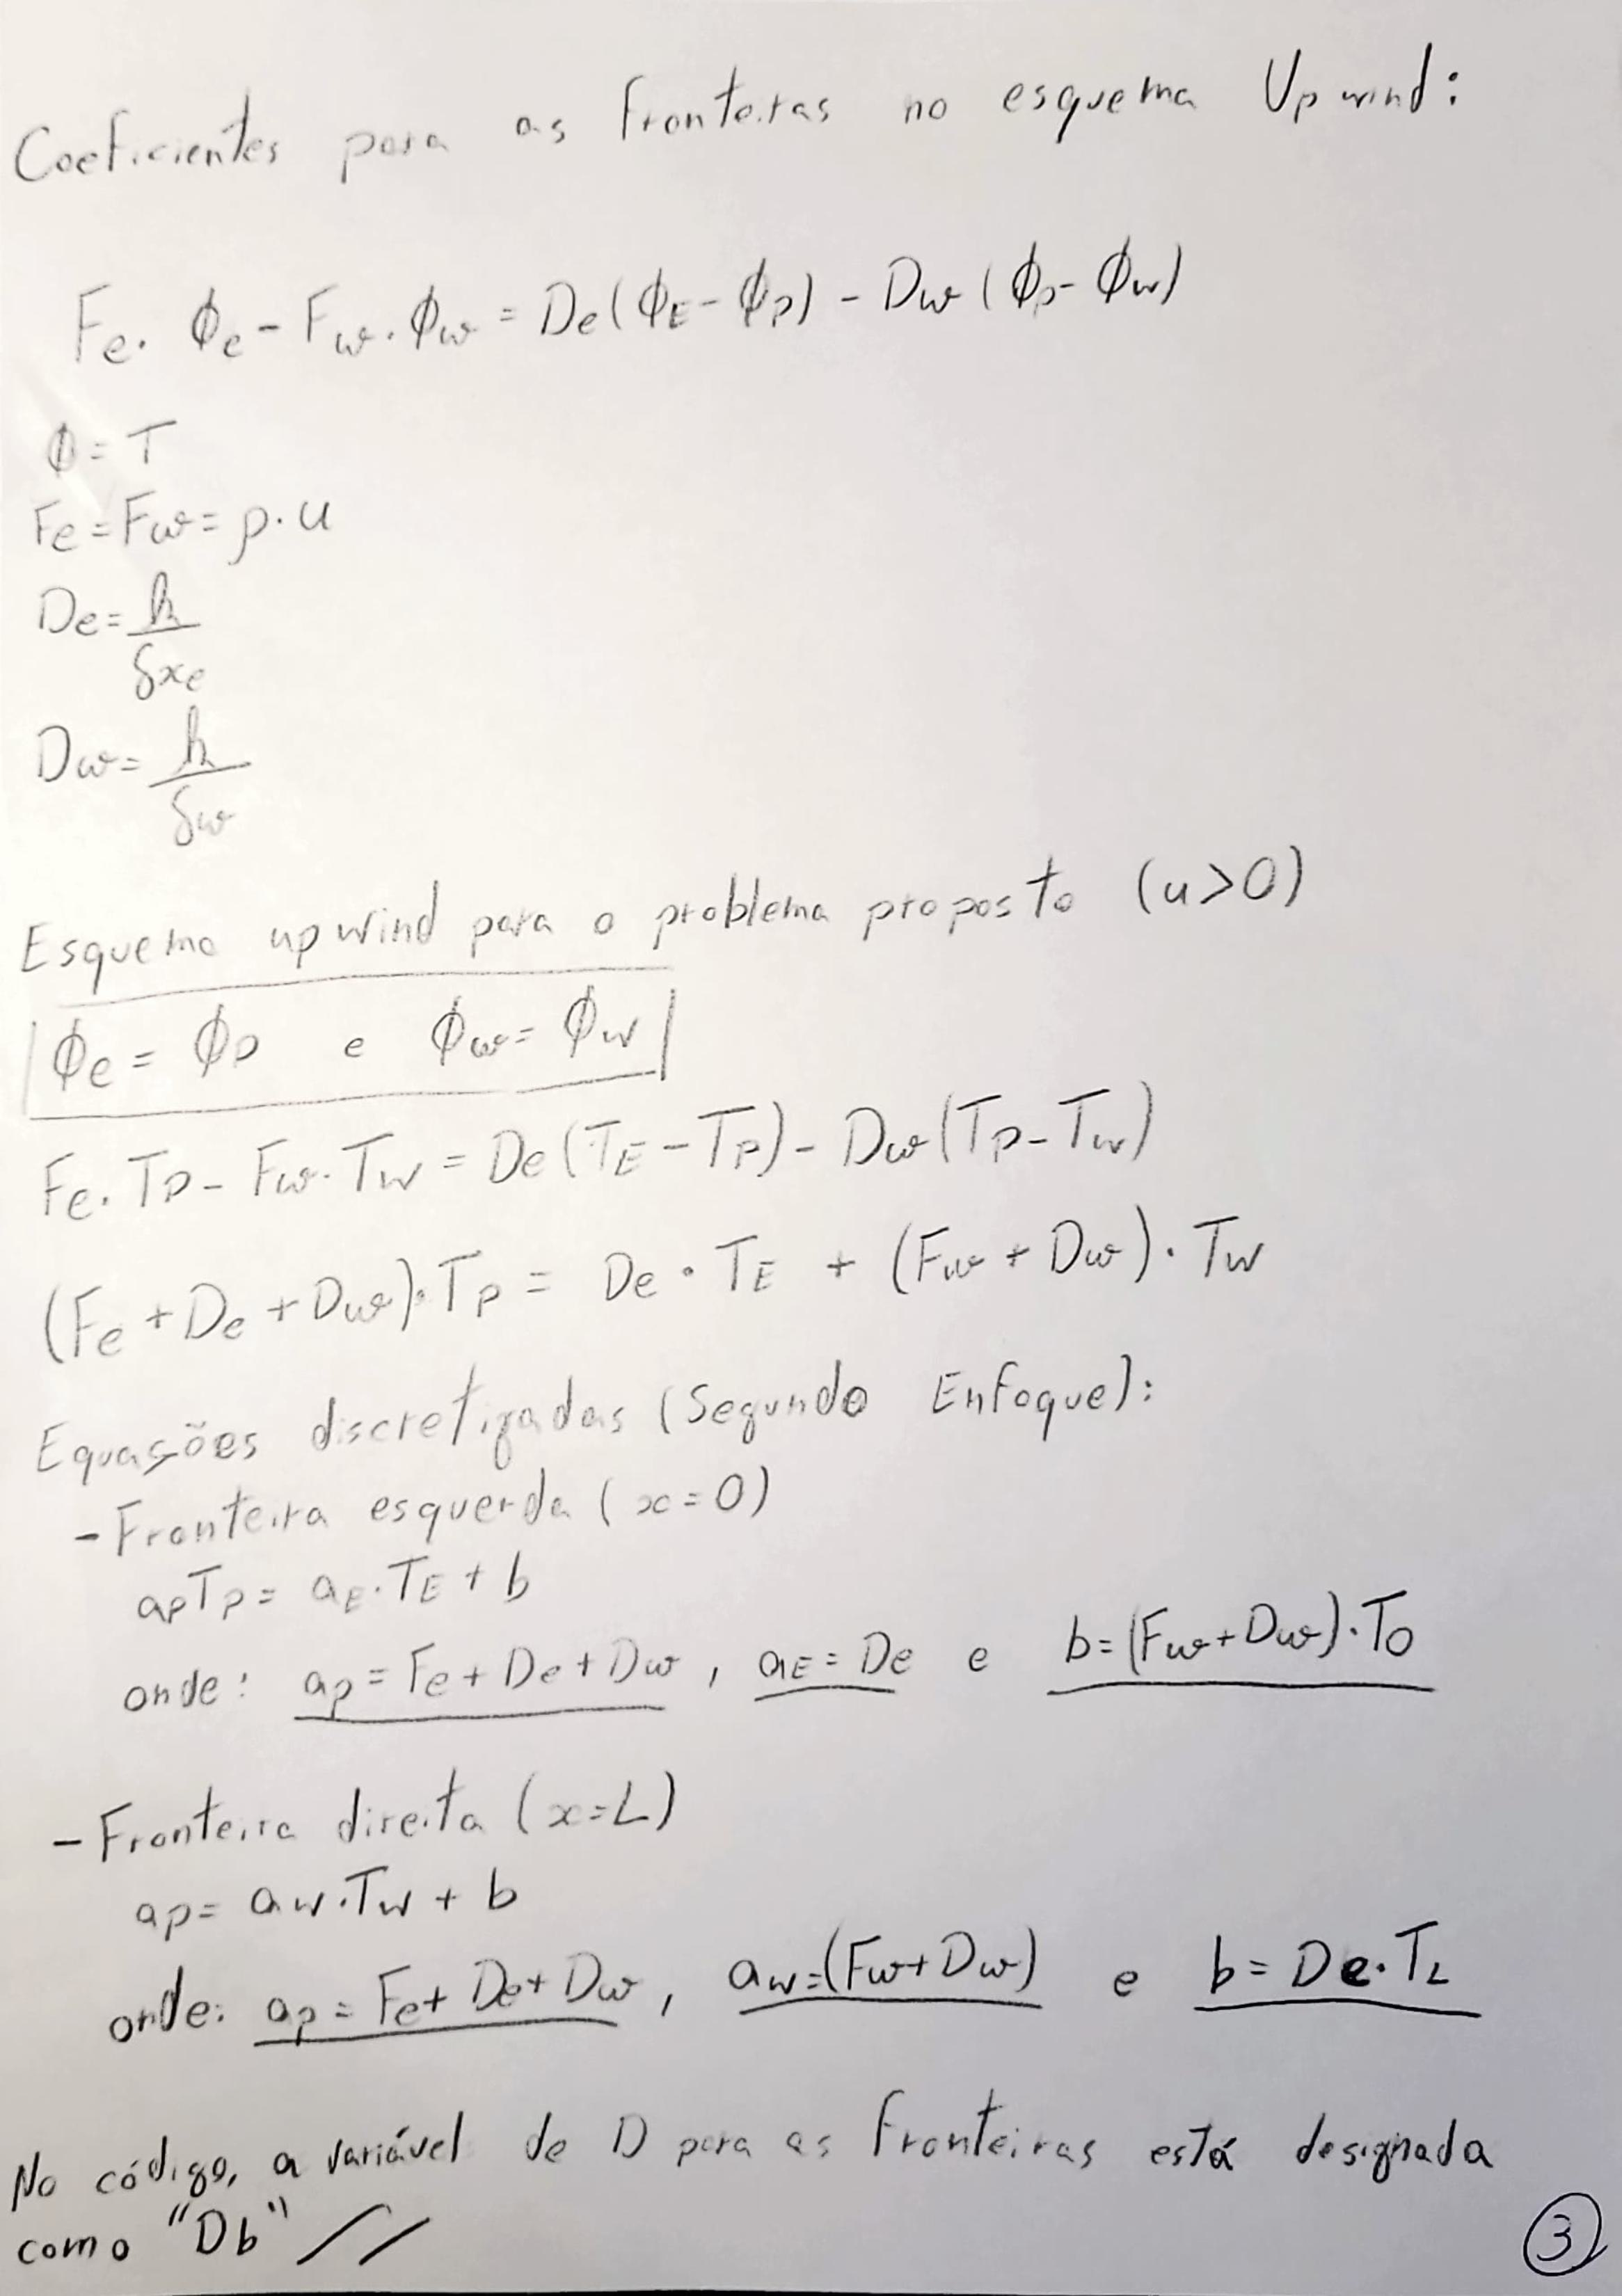

In [5]:
Image('Lista7_pag3.jpg',width=600)

No código, "Db" indica a o valor de D nos nós de fronteira.

## 2 Código

In [6]:
def calcular_coeficientes_convec_difus(n_cv, L, k, rho, u, T0, TL, esquema='EDC'):
    dx = L / n_cv
    F = rho * u        # Fluxo convectivo
    D = k / dx         # Condutância difusiva
    dxb = dx/2
    Db = k / dxb
    
    a, b, c, d = np.zeros(n_cv), np.zeros(n_cv), np.zeros(n_cv), np.zeros(n_cv)
    
    for i in range(n_cv):
            if esquema == 'EDC':
                aw, ae = D + F/2, D - F/2 #
                b_fonte = 0
                ap = aw + ae

                if i == 0: # Fronteira Esquerda (Dirichlet T0)
                        aw = 0
                        ap =  (D+Db)
                        b_fonte = (Db + F/2) * T0
                        #testetesteteste

                elif i == n_cv - 1: # Fronteira Direita (Dirichlet TL)
                        ae = 0
                        ap = D + Db
                        b_fonte = (Db - F/2) * TL

            else: # Upwind (u > 0)
                aw, ae = D + max(F,0), D + max(-F,0)        #
                b_fonte = 0
                ap = aw + ae

                if i == 0: # Fronteira Esquerda (Dirichlet T0)
                    aw = 0
                    ae = D
                    ap = F + D + Db
                    b_fonte = (F + Db) * T0

                elif i == n_cv - 1: # Fronteira Direita (Dirichlet TL)
                    ae = 0
                    aw = D + F
                    ap = F + D + Db
                    b_fonte = (Db) * TL
                
            a[i], b[i], c[i], d[i] = -aw, ap, -ae, b_fonte

    return a, b, c, d

# --- 3. Solução Analítica ---
def solucao_analitica(x, rho, u, k, L, T0, TL):
    Pe_L = (rho * u * L) / k
    return T0 + (TL - T0) * (np.exp(rho * u * x / k) - 1) / (np.exp(Pe_L) - 1)

## 3. Loop de Simulação e Plotagem
Resolvendo os três casos propostos e plotando os resultados, comparando-os com a solução analítica.

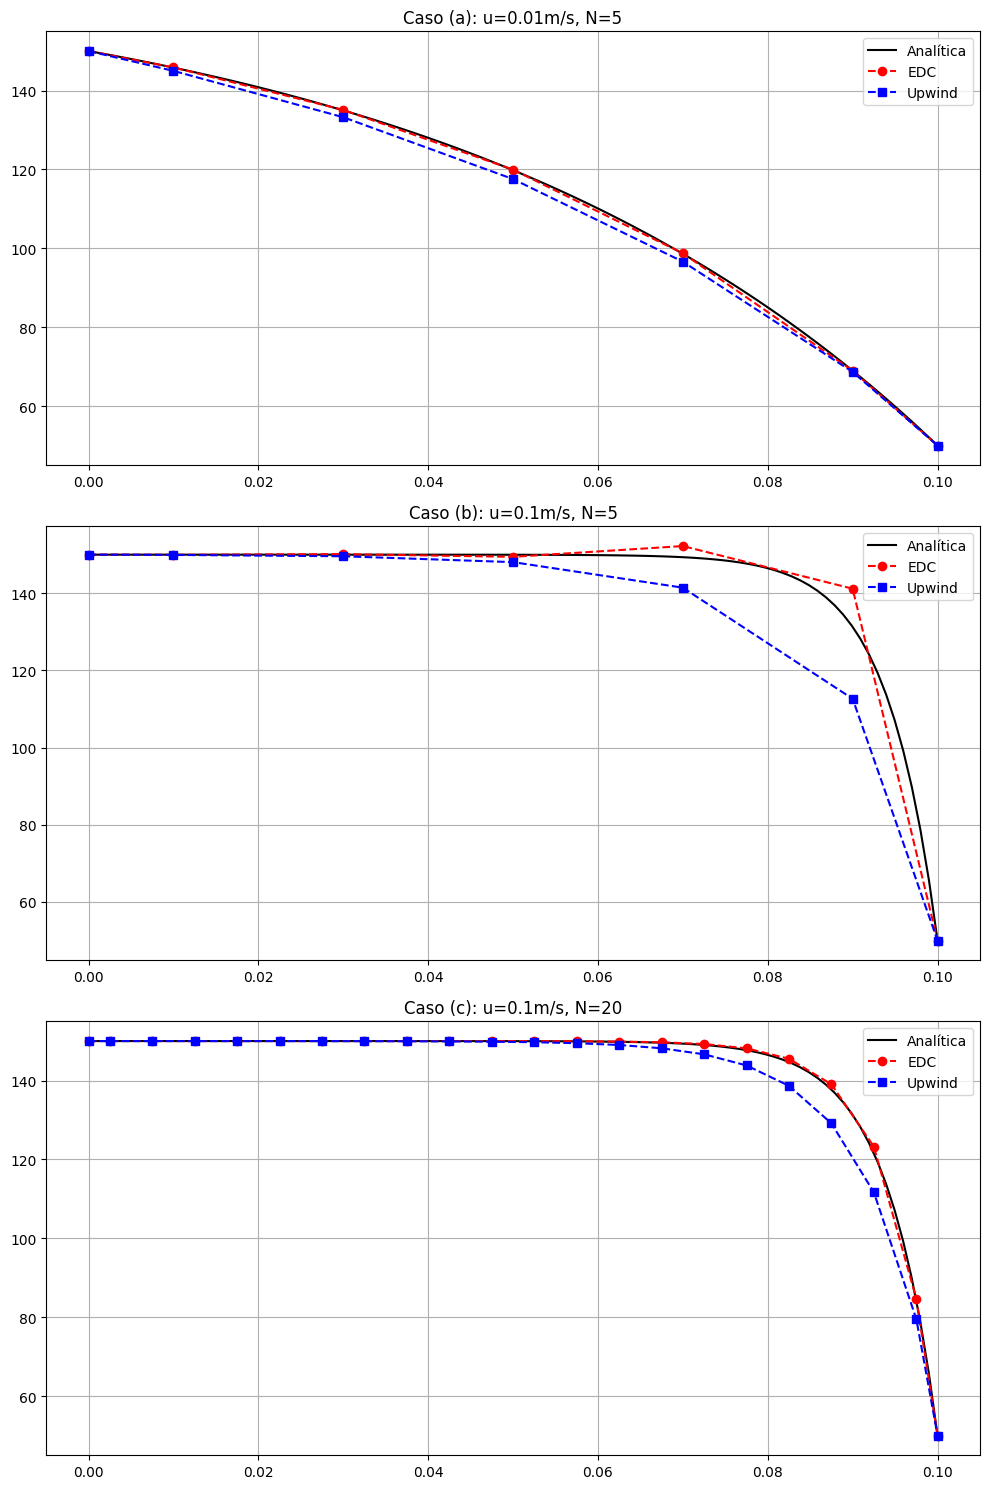

In [7]:
# --- 4. Execução dos Casos ---
parametros = [
    {'u': 0.01, 'N': 5, 'id': 'a'},
    {'u': 0.10, 'N': 5, 'id': 'b'},
    {'u': 0.10, 'N': 20, 'id': 'c'}
]

fig, axs = plt.subplots(3, 1, figsize=(10, 15))
for idx, p in enumerate(parametros):
    u, N = p['u'], p['N']
    x_nos = np.linspace(L/(2*N), L - L/(2*N), N)
    
    # Numérico
    a_c, b_c, c_c, r_c = calcular_coeficientes_convec_difus(N, 0.1, 0.595, 997, u, 150, 50, 'EDC')
    T_edc = solver_tdma(a_c, b_c, c_c, r_c)
    
    a_u, b_u, c_u, r_u = calcular_coeficientes_convec_difus(N, 0.1, 0.595, 997, u, 150, 50, 'Upwind')
    T_up = solver_tdma(a_u, b_u, c_u, r_u)
    
    # Analítico
    x_ref = np.linspace(0, 0.1, 100)
    T_ana = solucao_analitica(x_ref, 997, u, 0.595, 0.1, 150, 50)
    
    axs[idx].plot(x_ref, T_ana, 'k-', label='Analítica')
    axs[idx].plot(np.concatenate(([0], x_nos, [0.1])), np.concatenate(([150], T_edc, [50])), 'ro--', label='EDC')
    axs[idx].plot(np.concatenate(([0], x_nos, [0.1])), np.concatenate(([150], T_up, [50])), 'bs--', label='Upwind')
    axs[idx].set_title(f"Caso ({p['id']}): u={u}m/s, N={N}")
    axs[idx].legend(); axs[idx].grid(True)

plt.tight_layout(); plt.show()

## 2 Discussão dso resultados

Caso (a): Com $u = 0,01 \, m/s$ e $N = 5$, o número de Peclet local é baixo ($Pe \approx 0,33$), e ambos os esquemas apresentam boa concordância com a solução analítica.

Caso (b): Com $u = 0,10 \, m/s$ e $N = 5$, temos $Pe \approx 3,35$. Como $Pe > 2$, o esquema CDS apresenta resultados não realistas, enquanto o Upwind permanece estável, embora menos acurado.

Caso (c): Ao aumentar o número de volumes para $N = 20$, o Peclet local cai para $Pe \approx 0,84$. O esquema CDS volta a ser estável e apresenta uma precisão superior ao Upwind por ser de segunda ordem.